## Install Required Packages

In [71]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
os.chdir("/Users/yuanliu/Documents/Erasmus University/MSc Quantitive Marketing and Business Analytics/P3/Seminar Case Study/Data/case_studies_ah/")

In [72]:
%%capture 
pip install pyarrow

In [73]:
%%capture 
pip install fastparquet

In [74]:
%%capture
pip install ipywidget

## Import Libraries

In [165]:
import copy
from pathlib import Path
import warnings
import datetime

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

from sklearn.metrics import mean_absolute_percentage_error

plt.style.use('ggplot')

colors = plt.cm.Spectral(np.linspace(0,1,30))
plt.rcParams["figure.figsize"] = (20,5)

# Set Seeds
seed_no = 7
np.random.seed(seed_no)
torch.manual_seed(seed_no);

## Import Data
This notebook works the same for all three commodities, first we define the commodity of interest. Choices:
- SUNFLOWER OIL
- MAIZE
- WHEAT

In [166]:
product_type = "MAIZE"
date_filter = datetime.date(year = 2018, month = 1, day = 1)
date_end = datetime.date(year = 2022, month = 10, day = 1)

In [167]:
# load data from target commodity
if product_type == "WHEAT":
    trade_data = pd.read_csv("Data/wheat.csv")
    
if product_type == "MAIZE":
    trade_data = pd.read_csv("Data/maize_corn.csv")
    
if product_type == "SUNFLOWER OIL":
    trade_data = pd.read_csv("Data/sunflower_oil.csv")
    
# Add Time Period steps
trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})

# Make sure that the right product is isolated
products = trade_data["product"].drop_duplicates().to_list()

if product_type == 'SUNFLOWER OIL' or product_type == 'MAIZE':
    product_filter = products[0]

if product_type == 'WHEAT':
    product_filter = products[1]
        
# Add correct labels to the partner and declarent indices
    
partner_countries = pd.read_csv("Data/partners.csv", sep = ";")
trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
trade_data_pivot = trade_data_pivot.reset_index()
trade_data_pivot = trade_data_pivot.dropna()

# Dataframe for total trade data per month which we are forecasting
trade_data_total = trade_data_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

trade_data_total = trade_data_total.reset_index()
trade_data_total['price'] = trade_data_total['OBS_VALUE_VALUE_1000EURO']/trade_data_total['OBS_VALUE_QUANTITY_TON']
trade_data_total = trade_data_total[(trade_data_total["product"] == product_filter)]

trade_data_total = trade_data_total.set_index("TIME_PERIOD")
trade_data_total = trade_data_total[(trade_data_total.index >= date_filter)]

# Add 2 month rolling average for later validation
trade_data_total['MA2'] = trade_data_total["price"].rolling(window=2).mean()
trade_data_total['MA3'] = trade_data_total["price"].rolling(window=3).mean()

# Import other commodities and use same procedure
oil_data = pd.read_csv("Data/CMO-Historical-Data-Monthly.csv", header = 6)
oil_data = oil_data.rename(columns = {"Unnamed: 0" : "TIME_PERIOD"})
oil_data['TIME_PERIOD'] = oil_data['TIME_PERIOD'].str.replace(r'M', '-')
oil_data["TIME_PERIOD"] = pd.to_datetime(oil_data["TIME_PERIOD"], format = '%Y-%m').dt.date
to_replace = oil_data["SUNFLOWER_OIL"].iloc[0]
oil_data = oil_data.replace(to_replace, 0)
oil_data = oil_data.drop_duplicates()
oil_data = oil_data.set_index("TIME_PERIOD")
oil_data = oil_data[(oil_data.index >= date_filter) & (oil_data.index <= date_end)]

# Isolate Ukraine - Netherlands Import data for later use
Ukr_Data = trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Ukraine') & (trade_data_pivot["product"] == product_filter) & (trade_data_pivot["TIME_PERIOD"] >= date_filter)][['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']]
Ukr_Data = Ukr_Data.set_index("TIME_PERIOD")
Ukr_Data = Ukr_Data.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "UKR_QUANTITY"})
trade_data_total['UKR_QUANTITY'] = Ukr_Data['UKR_QUANTITY']
trade_data_total = trade_data_total.fillna(0)

# Import NOAA weather data
weather_data = pd.read_csv("Data/global_temperature_data.csv")
weather_data = weather_data.rename(columns = {"yearmonth" : "TIME_PERIOD"})
weather_data["TIME_PERIOD"] = pd.to_datetime(weather_data["TIME_PERIOD"], format = '%Y%m').dt.date
weather_data = weather_data.set_index("TIME_PERIOD")
weather_data = weather_data[(weather_data.index >= date_filter) & (weather_data.index <= date_end)]

weather_ukr = weather_data[weather_data['weather_countryname'] == 'Ukraine']
weather_fr = weather_data[weather_data['weather_countryname'] == 'France']
weather_ger = weather_data[weather_data['weather_countryname'] == 'Germany']

# Merge data to one frame 
data = trade_data_total.merge(oil_data, on = 'TIME_PERIOD')
data = data[data.columns.drop(list(data.filter(regex='Unnamed')))]

data['UKRMA3'] = trade_data_total["UKR_QUANTITY"].rolling(window=3).mean()

data['avgTempUkr'] = weather_ukr["AVG_TAVG"] / 10
data['avgTempFr'] = weather_fr["AVG_TAVG"] / 10
data['avgTempGer'] = weather_ger["AVG_TAVG"] / 10


Add date variables

In [168]:
data['product'] = data['product'].astype(str)
data['timeidx'] = range(len(data))

data['year'] = pd.DatetimeIndex(data.index).year.astype(str).astype('category')
data['month'] = pd.DatetimeIndex(data.index).month.astype(str).astype('category')

test_split = datetime.date(year = 2021, month = 1, day = 1)
training_data = data[(data.index < test_split)]

# Add MA2 
data['NGAS_EUR_MA2'] = data["NGAS_EUR"].rolling(window=2).mean()
data['CRUDE_PETRO_MA2'] = data["CRUDE_PETRO"].rolling(window=2).mean()

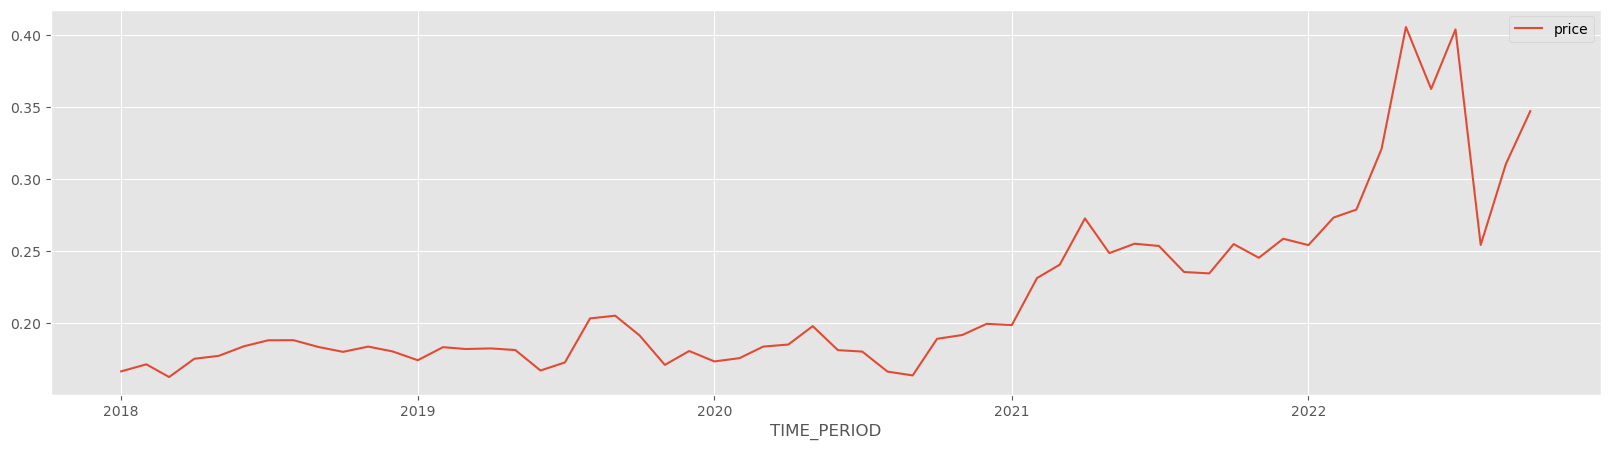

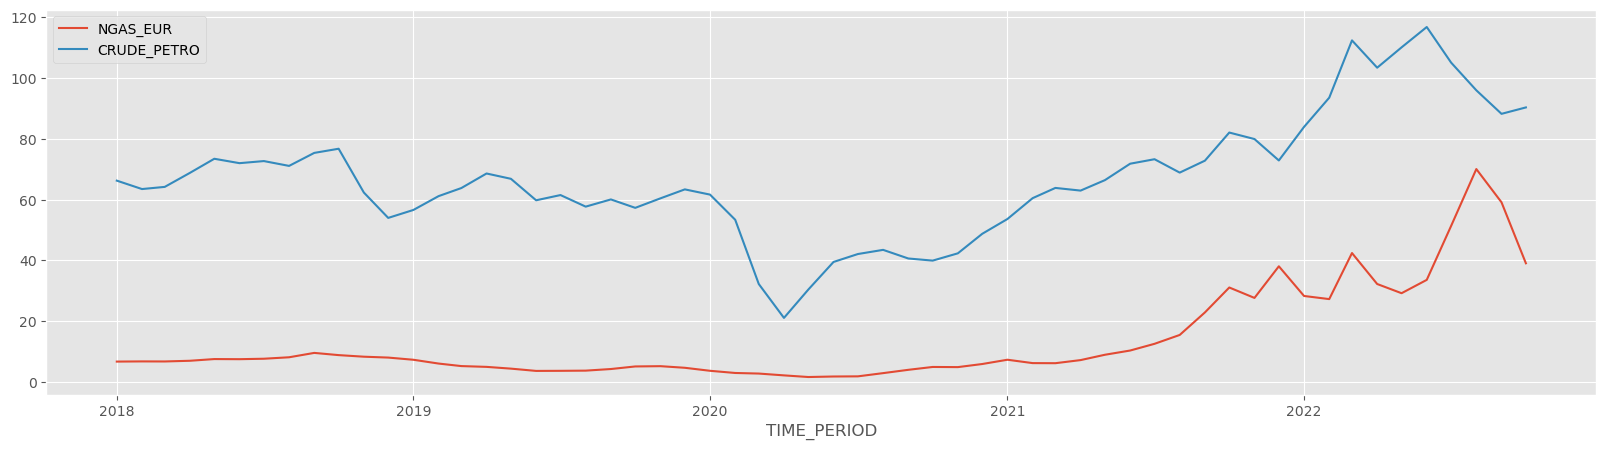

In [169]:
data[['price']].plot();
data[['NGAS_EUR', 'CRUDE_PETRO']].plot();

## Set-up Model

Select the validation window (max_prediction_length) consisting of the number of final months of the war and the training window (max_encoder_length)

Notes:
- If validating: max_prediction_length gives the number of months to forecast at the end of the war
- If out of sample forecast: max_prediction length should be set to 6
- trainig_cutoff should be set to the upper value if validating, otherwise it is the length of the reduced dataset - months in to war speaks for itself, if we are less far into the war we have less training data and shoul drop some months 

In [170]:
max_prediction_length = 6
max_encoder_length = 18 # 18 for scenario forecasting

# Set to len(data) - max_prediction_lenth if we want to assess in sample loss
training_cutoff = len(data)
target_feat = "price" #price, MA2

# For in sample validation, set to end of war (7) and control the forecast window with max_prediction_length
months_into_war = 7
months_to_drop = 7 - months_into_war

if months_to_drop == 0:
    reduced_data_set = data.copy()

else:
    reduced_data_set = data.head(- months_to_drop)

# Uncomment if not validating
# training_cutoff = len(reduced_data_set) 


if target_feat == "MA2":
    reduced_data_set = reduced_data_set.iloc[3:]

if target_feat == "MA6":
    reduced_data_set = reduced_data_set.iloc[6:]

    
training = TimeSeriesDataSet(
    # SWITCHED FROM DATA
    reduced_data_set[lambda x: x.timeidx <= training_cutoff],
    time_idx="timeidx",
    target=target_feat,
    group_ids=["product"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["product"],
    static_reals=[],
    time_varying_known_categoricals=["month"],
    time_varying_known_reals= [
        "timeidx", 
        "NGAS_EUR", 
        "CRUDE_PETRO", 
        "UKR_QUANTITY"
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        target_feat,
        "OBS_VALUE_QUANTITY_TON",
        "OBS_VALUE_VALUE_1000EURO",
        "MAIZE",
        "WHEAT_US_HRW",
        "SUNFLOWER_OIL",
    ],
    target_normalizer=GroupNormalizer(
        # Earlier GroupNormalizer
        groups=["product"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series\
validation = TimeSeriesDataSet.from_dataset(training, reduced_data_set, predict=True, stop_randomization=True)

# SWITCHED FROM DATA
# validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create seeded dataloaders
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_no)

batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, worker_init_fn=seed_worker,
    generator=g)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0, worker_init_fn=seed_worker,
    generator=g)


## Hyperparameter Tuning

In [56]:
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=300,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=60),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# show best hyperparameters
print(study.best_trial.params)
print(study.best_trial.value);

[I 2023-03-06 18:13:27,458] A new study created in memory with name: no-name-ae32d4f6-5c08-4c21-80ab-ba07e383c224
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[I 2023-03-06 18:13:33,887] Trial 0 finished with value: 0.21196967363357544 and parameters: {'gradient_clip_val': 0.8206920860560911, 'hidden_size': 113, 'dropout': 0.1589476160878373, 'hidden_continuous_size': 9, 'attention_head_size': 2, 'learning_rate': 0.0029206907156990275}. Best is trial 0 with value: 0.21196967363357544.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[W 2023-03-06 18:13:34,015] Trial 1 failed because of the following error: IndexError('list index out of range')
Traceback (most recent call last):
  File "/Users/yuanliu/opt/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 213, 

## Save Best Results

### For in-sample validation:
Uncomment below when using the hyperparameter optimization tool above

In [137]:
# res = study.best_trial.params


# gradient_clip_val = res['gradient_clip_val']
# hidden_size = res['hidden_size']
# dropout = res['dropout']
# hidden_continuous_size = res['hidden_continuous_size']
# attention_head_size = res['attention_head_size']
# learning_rate = res['learning_rate']

### For scenario forecasting:
Use best hyperparameter configurations found per target commodity 

In [171]:
# load data from target commodity
if product_type == "WHEAT":
    res = [0.756836784, 80, 0.206806068, 49, 2, 0.071267492]
    
if product_type == "MAIZE":
    res = [0.464546909, 46, 0.184018151, 18, 3, 0.019534113]
    
if product_type == "SUNFLOWER OIL":
    res = [0.379754699, 118, 0.14986229, 61, 4, 0.082224116]
                             
gradient_clip_val = res[0]
hidden_size = res[1]
dropout = res[2]
hidden_continuous_size = res[3]
attention_head_size = res[4]
learning_rate = res[5]

## Configure Network and Trainer
Set early stopping mechanism on too small (1e-4) quantile loss in 10 steps and set the loggers

In [176]:
# Some of PyTorch RNN/LSTM components have non-deterministic parts, need to set deterministic to True to ensure reproducibility
# Comment in if one aims to do iterative research
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs") 

# Configure Trainer
trainer = pl.Trainer(
    max_epochs=400,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=gradient_clip_val,
    limit_train_batches=30,  
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)

# Fit the model on the data
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
best_tft = tft
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 504   
4  | static_variable_selection          | VariableSelectionNetwork        | 8.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 33.4 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 14.6 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 8.7 K 
8  | static

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Locally save model using save(state_dict())

In [177]:
# torch.save(best_tft, "sunfloweroil_seed1.pth")
torch.save(best_tft.state_dict(), 'Pre-Trained_Models/maize_seed7.pth')


## Plotting the In-Sample Validation Results

In [178]:
data_plotter = data.copy()
data_plotter["timeidx_mov"] = data_plotter["timeidx"] - (len(data_plotter) - max_prediction_length)
    
MA2_val = list(data_plotter['MA2'].tail(max_prediction_length))
price_val = list(data_plotter['price'].tail(max_prediction_length))
    
y_pred = best_tft.to_quantiles(raw_predictions)
target =  torch.FloatTensor(price_val)


Quantile Loss =  0.004


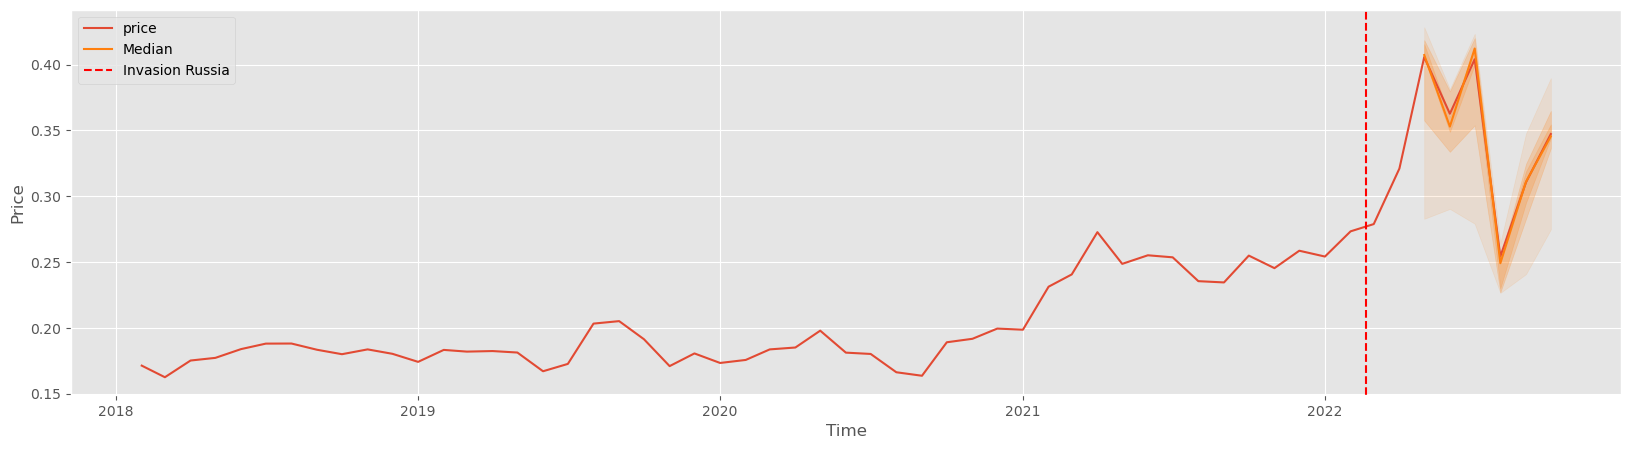

In [179]:
def forecaster_plotter(raw_dat, raw_predictions, data):
    q02, q10, q25, q5, q75, q90, q98 = [], [], [], [], [], [], []
    
    for i in range(len(raw_predictions[0])):
        q02.append(sorted(raw_predictions[0][i])[0].item())
        q10.append(sorted(raw_predictions[0][i])[1].item())
        q25.append(sorted(raw_predictions[0][i])[2].item())
        q5.append(sorted(raw_predictions[0][i])[3].item())
        q75.append(sorted(raw_predictions[0][i])[4].item())
        q90.append(sorted(raw_predictions[0][i])[5].item())
        q98.append(sorted(raw_predictions[0][i])[6].item())
                
    data_plotter = data.copy()
    data_plotter["timeidx_mov"] = data_plotter["timeidx"] - (len(data_plotter) - max_prediction_length)
    
    MA2_val = list(data_plotter['MA2'].tail(max_prediction_length))
    price_val = list(data_plotter['price'].tail(max_prediction_length))
    
    MAPE_MA2 = mean_absolute_percentage_error(q5, MA2_val)
    MAPE_price = mean_absolute_percentage_error(q5, price_val)
    y_pred = best_tft.to_quantiles(raw_dat)
    target =  torch.FloatTensor(price_val)
    
    print('Quantile Loss = ', "{:.3f}".format(torch.mean(QuantileLoss().loss(y_pred, target))))
#     print('MAPE MA2 = ', "{:.3f}".format(MAPE_MA2))
#     print('MAPE price = ', "{:.3f}".format(MAPE_price))

    index_list = list(reduced_data_set.index.values)
    used_list = index_list[-max_prediction_length:]
    
    ax = data_plotter[(data_plotter.index > date_filter)][["price"]].plot()
    plt.fill_between(used_list, q02, q98, alpha = 0.1, color = 'tab:orange')
    plt.fill_between(used_list, q10, q90, alpha = 0.2, color = 'tab:orange')
    plt.fill_between(used_list, q25, q75, alpha = 0.2, color = 'tab:orange')

    plt.plot(used_list, q5, color = 'tab:orange', label = 'Median')
    plt.axvline(datetime.datetime(2022, 2, 20), color = 'red', linestyle = '--', label = 'Invasion Russia')

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

forecaster_plotter(raw_predictions, raw_predictions['prediction'], data)   

## Scenario Forecasting

Alter the data for Scenario Forecasting

In [180]:
def situation_simulator(energyPrices, tradingIntensity):
    last_data = data[lambda x: x.timeidx == (x.timeidx.max())]
    lastGas = last_data["NGAS_EUR"].item()
    lastOil = last_data["CRUDE_PETRO"].item()
    lastQuant = last_data["UKR_QUANTITY"].item()
    
    max_quantity = data[(data.index >= datetime.date(year = 2020, month = 2, day = 1)) & (data.index <= datetime.date(year = 2022, month = 2, day = 1))]["UKR_QUANTITY"].mean()
    max_GasPrice = data["NGAS_EUR"].max()
    max_OilPrice = data["CRUDE_PETRO"].max()
    
    very_high_peak_trade = max_quantity * 2
    high_peak_trade = max_quantity * 1.5
    moderate_peak_trade = max_quantity * 1
    
    very_high_peak_gas = max_GasPrice * 1.5
    high_peak_gas = max_GasPrice * 0.75
    moderate_peak_gas = max_GasPrice * 0.5
    low_peak_gas = max_GasPrice * 0.2
    
    very_high_peak_oil = max_OilPrice * 1.5
    high_peak_oil = max_OilPrice * 0.75
    moderate_peak_oil = max_OilPrice * 0.5
    low_peak_oil = max_OilPrice * 0.2

    if tradingIntensity == "Low":
        simDataTrade = [0] * max_prediction_length
    
    if tradingIntensity == "Moderate":
        difTrade = moderate_peak_trade - (lastQuant)
        simDataTrade = [lastQuant + (difTrade) / 2] + [moderate_peak_trade] * (max_prediction_length - 1)

    if tradingIntensity == "High":
        difTrade = high_peak_trade - (lastQuant)
        simDataTrade = [lastQuant + (difTrade) / 2] + [high_peak_trade] * (max_prediction_length - 1)

    if tradingIntensity == "Very High":
        difTrade = very_high_peak_trade - (lastQuant)
        simDataTrade = [lastQuant + (difTrade) / 2] + [very_high_peak_trade] * (max_prediction_length - 1)
        
        
    if energyPrices == "Low":
        difGas = low_peak_gas - lastGas
        difOil = low_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [low_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [low_peak_oil] * (max_prediction_length - 1)
    
    if energyPrices == "Moderate":
        difGas = moderate_peak_gas - lastGas
        difOil = moderate_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [moderate_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [moderate_peak_oil] * (max_prediction_length - 1)

    if energyPrices == "High":
        difGas = high_peak_gas - lastGas
        difOil = high_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [high_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [high_peak_oil] * (max_prediction_length - 1)

    if energyPrices == "Very High":
        difGas = very_high_peak_gas - lastGas
        difOil = very_high_peak_oil - lastOil
        simDataGas = [lastGas + (difGas) / 2] + [very_high_peak_gas] * (max_prediction_length - 1)
        simDataOil = [lastOil + (difOil) / 2] + [very_high_peak_oil] * (max_prediction_length - 1)
            
    return simDataGas, simDataOil, simDataTrade    
    

In [181]:
simDataGas, simDataOil, simDataTrade = situation_simulator("Low", "Low")

encoder_data = data[lambda x: x.timeidx > x.timeidx.max() - max_encoder_length]
last_data = data[lambda x: x.timeidx == x.timeidx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.index + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

decoder_data["timeidx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["timeidx"] += encoder_data["timeidx"].max() + 1 - decoder_data["timeidx"].min()\

decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings
decoder_data["year"] = decoder_data.date.dt.year.astype(str).astype("category")  # categories have be strings

for i in range(max_prediction_length):
    replaceIndex = i
    
    replaceValueGas = simDataGas[replaceIndex]
    replaceValueOil = simDataOil[replaceIndex]
        
    decoder_data.loc[replaceIndex,'NGAS_EUR'] = replaceValueGas
    decoder_data.loc[replaceIndex,'CRUDE_PETRO'] = replaceValueOil

# # combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

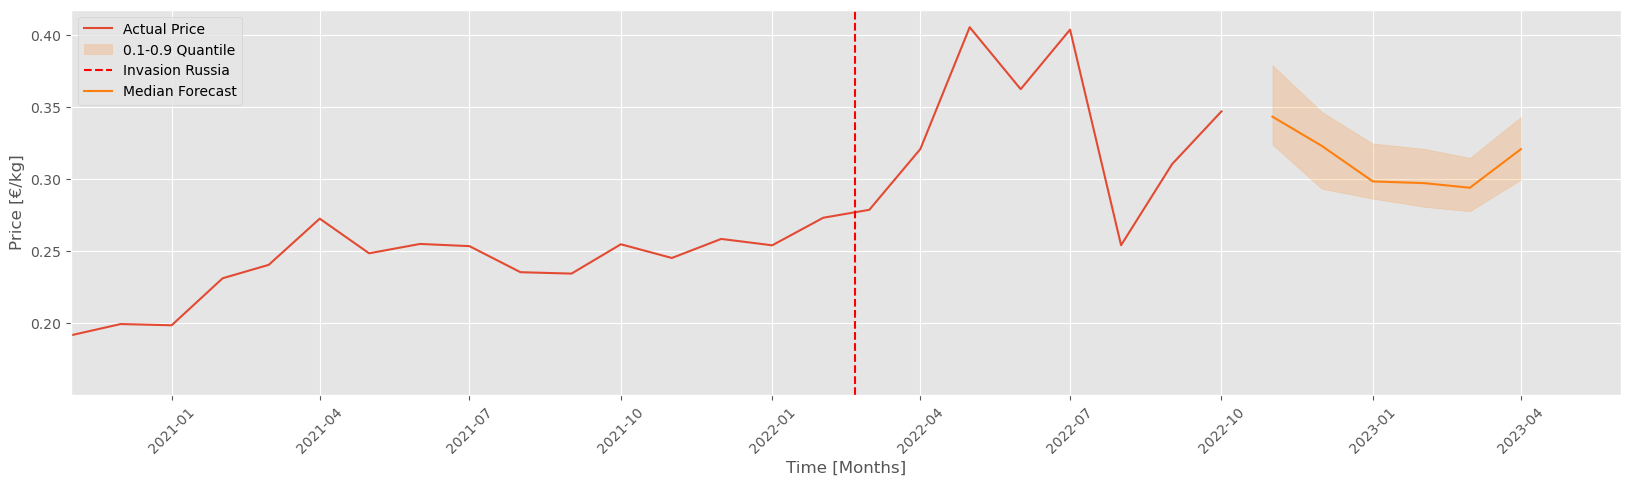

In [182]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

def sim_forecaster_plotter(raw_predictions, data, prediction_length):
    q02, q10, q25, q5, q75, q90, q98 = [], [], [], [], [], [], []
    
    for i in range(len(raw_predictions[0])):
        q02.append(sorted(raw_predictions[0][i])[0].item())
        q10.append(sorted(raw_predictions[0][i])[1].item())
        q25.append(sorted(raw_predictions[0][i])[2].item())
        q5.append(sorted(raw_predictions[0][i])[3].item())
        q75.append(sorted(raw_predictions[0][i])[4].item())
        q90.append(sorted(raw_predictions[0][i])[5].item())
        q98.append(sorted(raw_predictions[0][i])[6].item())
                
    data_plotter = data.copy()
    data_plotter["timeidx_mov"] = data_plotter["timeidx"] - (len(data_plotter) - prediction_length)
    
    last_data = data[lambda x: x.timeidx == x.timeidx.max()]
    
    # Get first month of forecast window
    first_month  = int(last_data["month"]) + 1 - months_to_drop
    first_year = int(last_data["year"])
    
    index_list = list(data_plotter.index.values)
    
    used_list_new = []
    
    for i in range(prediction_length):
        current_month = first_month + i
        current_year = first_year
        
        if current_month > 12:
            current_month = current_month - 12
            current_year = first_year + 1
        
        used_list_new.append(datetime.date(year = current_year, month = current_month, day = 1))
            
    used_list = index_list[-max_prediction_length:]
    
    ax = data_plotter[(data_plotter.index > date_filter)][[target_feat]].plot(label = 'Actual Price')
#     plt.fill_between(used_list_new, q02, q98, alpha = 0.2, color = 'tab:orange')
#     plt.fill_between(used_list_new, q25, q75, alpha = 0.2, color = 'tab:orange')
    plt.fill_between(used_list_new, q10, q90, alpha = 0.2, color = 'tab:orange')

    plt.axvline(datetime.datetime(2022, 2, 20), color = 'red', linestyle = '--', label = 'Invasion Russia')
    plt.xlim([datetime.date(2020, 11, 1), datetime.date(2023, 6, 1)]);
    plt.xticks(rotation = 45)
    plt.plot(used_list_new, q5, color = 'tab:orange', label = 'Median Forecast')
#     plt.ylim(0.6, 1.9)
    plt.xlabel('Time [Months]')
    plt.ylabel('Price [€/kg]')
    plt.legend(['Actual Price','0.1-0.9 Quantile', 'Invasion Russia', 'Median Forecast'], loc = 'upper left')
    
sim_forecaster_plotter(new_raw_predictions['prediction'], data, max_prediction_length)   

Visualize the different Scenarios

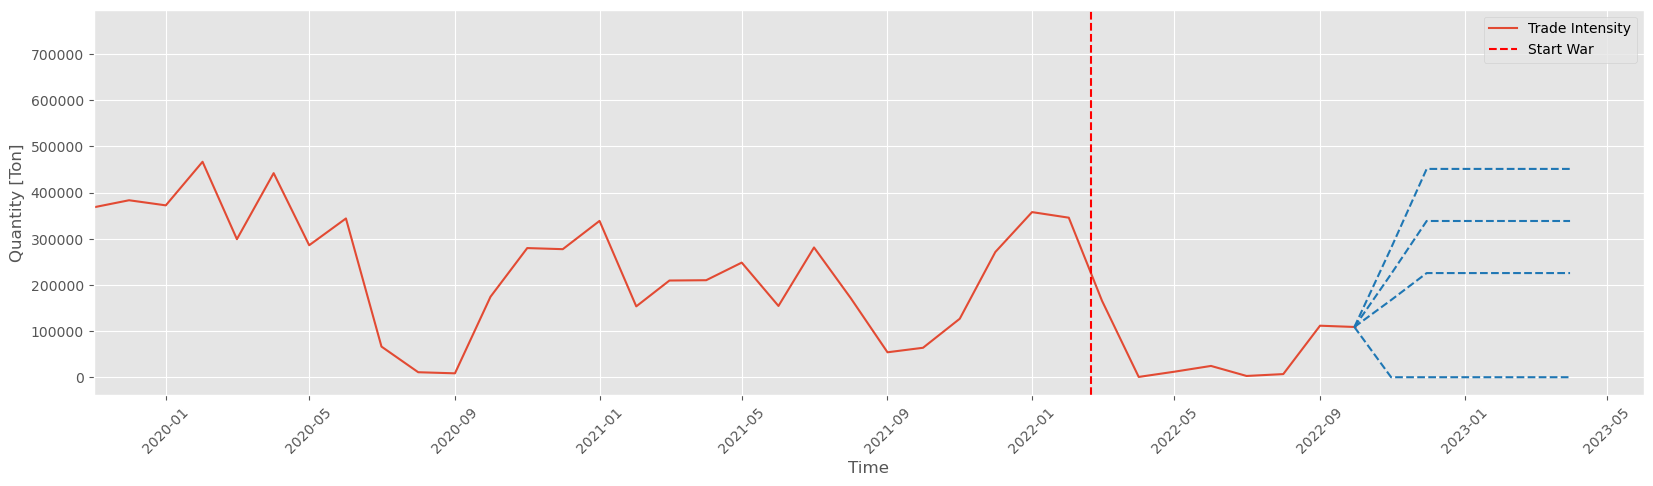

In [183]:
gasL, oilL, tradeL = situation_simulator("Low", "Low")
gasM, oilM, tradeM = situation_simulator("Moderate", "Moderate")
gasH, oilH, tradeH = situation_simulator("High", "High")
gasVH, oilVH, tradeVH = situation_simulator("Very High", "Very High")

final_oil_price = oil_data.tail(1)['CRUDE_PETRO'].item()
final_gas_price = oil_data.tail(1)['NGAS_EUR'].item()
final_trade = data.tail(1)['UKR_QUANTITY'].item()

# display(data.tail())
gasL = [final_gas_price] + gasL
gasM = [final_gas_price] + gasM
gasH = [final_gas_price] + gasH
gasVH = [final_gas_price] + gasVH

# display(data.tail())
oilL = [final_oil_price] + oilL
oilM = [final_oil_price] + oilM
oilH = [final_oil_price] + oilH
oilVH = [final_oil_price] + oilVH

# display(data.tail())
tradeL = [final_trade] + tradeL
tradeM = [final_trade] + tradeM
tradeH = [final_trade] + tradeH
tradeVH = [final_trade] + tradeVH

plt.rcParams["figure.figsize"] = (20,5)

x = np.arange(len(data))
x_extr = pd.date_range(datetime.date(year=2022, month=9, day=1), periods=7, freq = 'm').tolist()
plt.plot(data.index, data["UKR_QUANTITY"], label = 'Trade Intensity')
# plt.plot(data.index, data["CRUDE_PETRO"], label = 'Oil Price')
# plt.plot(data.index, data["NGAS_EUR"], label = 'Gas Price')

# plt.plot(x_extr, gasL, color = 'tab:blue', linestyle = '--')
# plt.plot(x_extr, gasM, color = 'tab:blue', linestyle = '--')
# plt.plot(x_extr, gasH, color = 'tab:blue', linestyle = '--')
# plt.plot(x_extr, gasVH, color = 'tab:blue', linestyle = '--')

# plt.plot(x_extr, oilL, color = 'tab:red', linestyle = '--')
# plt.plot(x_extr, oilM, color = 'tab:red', linestyle = '--')
# plt.plot(x_extr, oilH, color = 'tab:red', linestyle = '--')
# plt.plot(x_extr, oilVH, color = 'tab:red', linestyle = '--')

plt.plot(x_extr, tradeL, color = 'tab:blue', linestyle = '--')
plt.plot(x_extr, tradeM, color = 'tab:blue', linestyle = '--')
plt.plot(x_extr, tradeH, color = 'tab:blue', linestyle = '--')
plt.plot(x_extr, tradeVH, color = 'tab:blue', linestyle = '--')

# last_data = data[lambda x: x.timeidx == (x.timeidx.max() - 6)]
# plt.scatter(data.timeidx.max() - 6, last_data["NGAS_EUR"].item())
plt.xlim([datetime.date(2019, 11, 1), datetime.date(2023, 6, 1)]);
# plt.ylim(0,20000)
plt.axvline(datetime.datetime(2022, 2, 20), color = 'red', linestyle = '--', label = 'Start War')
plt.xticks(rotation = 45)
plt.xlabel('Time')
plt.ylabel('Quantity [Ton]')
# plt.axvline(55, color = 'green', linestyle = '--', label = 'Start Forecast')
plt.legend();

In [184]:
plt.rcParams["figure.figsize"] = (5,5)

@widgets.interact(
    energyPrices=['Low', 'Moderate', 'High', 'Very High'], 
    tradingIntensity = ['Low', 'Moderate', 'High', 'Very High'])
def plotter(energyPrices, tradingIntensity):
    simDataGas, simDataOil, simDataTrade = situation_simulator(energyPrices, tradingIntensity)

    encoder_data = data[lambda x: x.timeidx > x.timeidx.max() - max_encoder_length]

    # select last known data point and create decoder data from it by repeating it and incrementing the month
    # in a real world dataset, we should not just forward fill the covariates but specify them to account
    # for changes in special days and prices (which you absolutely should do but we are too lazy here)
    last_data = data[lambda x: x.timeidx == x.timeidx.max()]
    decoder_data = pd.concat(
        [last_data.assign(date=lambda x: x.index + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
        ignore_index=True,
    )

    # add time index consistent with "data"
    decoder_data["timeidx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
    decoder_data["timeidx"] += encoder_data["timeidx"].max() + 1 - decoder_data["timeidx"].min()

    # adjust additional time feature(s)
    decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings
    decoder_data["year"] = decoder_data.date.dt.year.astype(str).astype("category")  # categories have be strings

    for i in range(max_prediction_length):
        replaceIndex = i

        replaceValueGas = simDataGas[replaceIndex]
        replaceValueOil = simDataOil[replaceIndex]
        replaceValueTrade = simDataTrade[replaceIndex]
        
        if target_feat == "price":
            replaceGas = "NGAS_EUR"
            replaceOil = "CRUDE_PETRO"
        
        if target_feat == "MA2":
            replaceGas = "NGAS_EUR_MA2"
            replaceOil = "CRUDE_PETRO_MA2"

        decoder_data.loc[replaceIndex, replaceGas] = replaceValueGas
        decoder_data.loc[replaceIndex, replaceOil] = replaceValueOil
        decoder_data.loc[replaceIndex, 'UKR_QUANTITY'] = replaceValueTrade
        
    # combine encoder and decoder data
    new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
    
    new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)        
    sim_forecaster_plotter(new_raw_predictions['prediction'], data, max_prediction_length)       

interactive(children=(Dropdown(description='energyPrices', options=('Low', 'Moderate', 'High', 'Very High'), v…

## Variables Importance and Attention

In [ ]:
# interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
# best_tft.plot_interpretation(interpretation);

## Sensitivity Analysis In-Sample Encoder Length

This module has an iterative loop included to make results over the number of validation windows. Results are provided in the report and result logs.

In [ ]:
max_prediction_length_list = [6,5,4,3,2]

QLoss_log = []
Hyperparameter_log = []
raw_data_log = []

for prediction_length in max_prediction_length_list:
    print("Max Prediction Length: ", prediction_length)
    max_prediction_length = prediction_length
    max_encoder_length = 12

    # Set to len(data) - max_prediction_lenth if we want to assess in sample loss
    training_cutoff = len(data)  - max_prediction_length
    target_feat = "price" #price, MA2

    # For in sample validation, set to end of war (7) and control the forecast window with max_prediction_length
    months_into_war = 7
    months_to_drop = 7 - months_into_war

    if months_to_drop == 0:
        reduced_data_set = data.copy()

    else:
        reduced_data_set = data.head(- months_to_drop)

    training = TimeSeriesDataSet(
        # SWITCHED FROM DATA
        reduced_data_set[lambda x: x.timeidx <= training_cutoff],
        time_idx="timeidx",
        target=target_feat,
        group_ids=["product"],
        min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["product"],
        static_reals=[],
        time_varying_known_categoricals=["month"],
        time_varying_known_reals= [
            "timeidx", 
            "NGAS_EUR",
            "CRUDE_PETRO", 
            "UKR_QUANTITY",
        ],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=[
            target_feat,
            "OBS_VALUE_QUANTITY_TON",
            "OBS_VALUE_VALUE_1000EURO",
            "MAIZE",
            "WHEAT_US_HRW",
            "SUNFLOWER_OIL",
        ],
        target_normalizer=GroupNormalizer(
            # Earlier GroupNormalizer
            groups=["product"], transformation="softplus"
        ),  # use softplus and normalize by group
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True
    )

    # create validation set (predict=True) which means to predict the last max_prediction_length points in time
    # for each series\
    validation = TimeSeriesDataSet.from_dataset(training, reduced_data_set, predict=True, stop_randomization=True)

    # SWITCHED FROM DATA
    # validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

    # create dataloaders for model
    batch_size = 128  # set this between 32 to 128
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
    
    # create study
    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path="optuna_test",
        n_trials=300,
        max_epochs=50,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(8, 128),
        hidden_continuous_size_range=(8, 128),
        attention_head_size_range=(1, 4),
        learning_rate_range=(0.001, 0.1),
        dropout_range=(0.1, 0.3),
        trainer_kwargs=dict(limit_train_batches=60),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    )
    
    res = study.best_trial.params

    gradient_clip_val = res['gradient_clip_val']
    hidden_size = res['hidden_size']
    dropout = res['dropout']
    hidden_continuous_size = res['hidden_continuous_size']
    attention_head_size = res['attention_head_size']
    learning_rate = res['learning_rate']
    
    Hyperparameter_log.append(res)
    
    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    trainer = pl.Trainer(
        max_epochs=400,
        gpus=0,
        enable_model_summary=True,
        gradient_clip_val=gradient_clip_val,
        limit_train_batches=30,  # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        callbacks=[lr_logger, early_stop_callback],
        logger=logger,
    )


    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=learning_rate,
        hidden_size=hidden_size,
        attention_head_size=attention_head_size,
        dropout=dropout,
        hidden_continuous_size=hidden_continuous_size,
        output_size=7,  # 7 quantiles by default
        loss=QuantileLoss(),
        log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience=4,
    )
    
    # fit network
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    best_tft = tft
    
    raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
    y_pred = best_tft.to_quantiles(raw_predictions)
    
    interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
    raw_data_log.append(raw_predictions)
    
#     best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)
#     plt.show()
    
    raw_predictions = raw_predictions['prediction']
    

    
    q02, q10, q25, q5, q75, q90, q98 = [], [], [], [], [], [], []
    
    for i in range(len(raw_predictions[0])):
        q02.append(sorted(raw_predictions[0][i])[0].item())
        q10.append(sorted(raw_predictions[0][i])[1].item())
        q25.append(sorted(raw_predictions[0][i])[2].item())
        q5.append(sorted(raw_predictions[0][i])[3].item())
        q75.append(sorted(raw_predictions[0][i])[4].item())
        q90.append(sorted(raw_predictions[0][i])[5].item())
        q98.append(sorted(raw_predictions[0][i])[6].item())
        
    data_plotter = data.copy()
    data_plotter["timeidx_mov"] = data_plotter["timeidx"] - (len(data_plotter) - max_prediction_length)
        
    MA2_val = list(data_plotter['MA2'].tail(max_prediction_length))
    price_val = list(data_plotter['price'].tail(max_prediction_length))
    
#     MAPE_MA2 = mean_absolute_percentage_error(q5, MA2_val)
#     MAPE_price = mean_absolute_percentage_error(q5, price_val)
    target =  torch.FloatTensor(price_val)
    print(torch.mean(QuantileLoss().loss(y_pred, target)))

    
#     MAPEMA2_log.append(MAPE_MA2)
#     MAPE_log.append(MAPE_price)
    QLoss_log.append(torch.mean(QuantileLoss().loss(y_pred, target)).item())
    
#     print('Quantile Loss = ', "{:.3f}".format(torch.mean(QuantileLoss().loss(y_pred, target)).item()))


In [ ]:
decoder_tot = np.zeros(len(feature_importance_log[0]['decoder_variables']))

rel_feature_importance_log = feature_importance_log[2:]

for log in rel_feature_importance_log:
    for var in range(len(log['decoder_variables'])):
        decoder_tot[var] += log['decoder_variables'][var]

decoder_rel = decoder_tot[2:(len(decoder_tot) - 1)]
variables = ["Total Import Quantity", "EU Natural Gas", "Crude Petro", "Ukraine Import Quantity", "Gold", "Avg Temp Ukraine", "Avg Temp France", "Avg Temp Ger"]
plt.barh(variables, decoder_rel / sum(decoder_rel) * 100)
plt.xlabel("Variable Importance [%]");

## Feature Importance 

Results of different runs are shown in Result Logs

In [ ]:
f2 = pd.DataFrame(np.array([[0.16,0.13,0.20,0.12,0.11,0.12,0.06,0.10], 
                            [0.09,0.18,0.18,0.15,0.12,0.09,0.10,0.09], 
                            [0.08,0.26,0.39,0.10,0.18,0.16,0.06,0.09]]), 
                  columns=["Total Import Quantity","European Natural Gas","Crude Oil","Ukraine Import Quantity","Gold","Average Temperature Ukraine","Average Temparture France","Average Temperature Germany"], 
                  index = ['Maize', 'Sunflower Oil', 'Wheat'])

f2 = f2 * 100

plt.rcParams["figure.figsize"] = (10,5)
colorsbarh = plt.cm.Spectral(np.linspace(0,1,8))
f2.plot.barh(color = colorsbarh)
plt.xlabel('Variable Importance [%]');